<a href="https://colab.research.google.com/github/Hadipiano94/Colab_Gym_AnyTrading/blob/master/gym_forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.13.0 keras gym-anytrading gym

In [ ]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, BatchNormalization, GRU
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


In [ ]:
df = pd.read_csv("USD-JPY_D1_mt5.csv", delimiter="\t", names=['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'vol', 'spr'])
df.drop(columns=['vol', 'spr'], inplace=True)
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
print(df)

custom_env information:
> shape: (50, 2)
> df.shape: (6144, 5)
> prices.shape: (194,)
> signal_features.shape: (194, 2)
> max_possible_profit: 1.6212478525231373


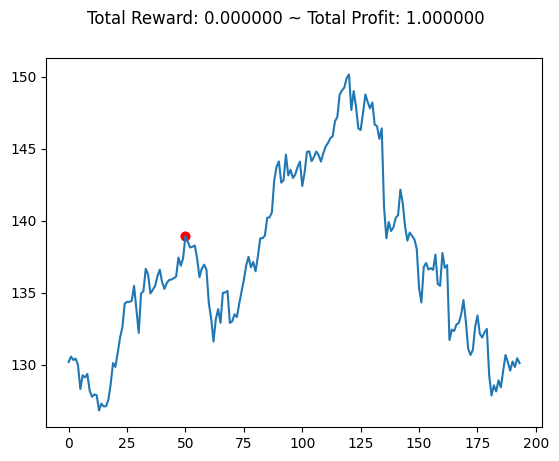

In [ ]:
env = gym.make(
    'forex-v0',
    df=df,
    window_size=50,
    frame_bound=(5856, 6000),
    unit_side='left'
)

print("custom_env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env.reset()
env.render()


In [ ]:
obs = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break
plt.figure(figsize=(15, 6))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [ ]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):

    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


prices, signal_features = my_process_data(df=df, window_size=30, frame_bound=(30, len(df)))
env = MyStocksEnv(prices, signal_features, df=df, window_size=30, frame_bound=(30, len(df)))

In [ ]:
env_maker = lambda: gym.make(
    'forex-v0',
    df=df,
    window_size=60,
    frame_bound=(5800, 6000),
    unit_side='left'
)

In [ ]:
"""The Model--------------------------------------------------------------------------------------------"""

class MyAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.n
        self.q_network = self.build_q_network()

    def build_q_network(self):

        model = Sequential()
        # model.add(LSTM(128, input_shape=(self.state_dim), return_sequences=True))
        # model.add(BatchNormalization())

        # model.add(LSTM(256, return_sequences=True))
        # model.add(Dropout(0.2))
        # model.add(BatchNormalization())

        # model.add(LSTM(128))
        # model.add(Dropout(0.2))
        # model.add(BatchNormalization())

        # model.add(Dense(256, activation='relu'))
        # model.add(Dropout(0.2))

        # model.add(Dense(128, activation='relu'))
        # model.add(Dropout(0.2))

        model.add(Dense(64, input_shape=(self.state_dim), activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(2, activation='softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])


        tensorboard = TensorBoard(log_dir="logs/{}".format('Agent_1'))

        filepath = f"RNN_Final-{time.time()}"
        checkpoint = ModelCheckpoint("models/{}.keras".format(filepath,
                                                              monitor='val_acc',
                                                              verbose=1,
                                                              save_best_only=True,
                                                              mode='max'))
        return model

    def train(self, num_episodes, epsilon=0.1):
        for episode in range(num_episodes):
            print(f"Episode no.{episode + 1}")
            state = self.env.reset()[0]
            done = False
            step = 1
            while not done:
                print(f"Step {step}")
                # Choose action based on epsilon-greedy policy
                if np.random.rand() < epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_network.predict(np.array([state])))

                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                # Q-learning update
                target = reward + np.max(self.q_network.predict(np.array([next_state])))
                target_vec = self.q_network.predict(np.array([state]))
                target_vec[0][action] = target
                self.q_network.fit(np.array([state]), target_vec, epochs=1, verbose=0)

                state = next_state

                step += 1

model = MyAgent(env)
model.train(1)


In [ ]:
env = gym.make(
    'forex-v0',
    df=df,
    window_size=60,
    frame_bound=(6000, 6143),
    unit_side='left'
)

obs = env.reset(seed=2023)[0]
while True:
    q_values = model.q_network.predict(np.array([obs]))
    action = np.argmax(q_values)
    # if action == 1:
      # action = 0
    # elif action == 0:
      # action = 1
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        print("info:", info)
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.unwrapped.render_all()
plt.show()